# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
pd.set_option('max.columns', None)

In [3]:
train = pd.read_csv('trainclean.csv')

In [4]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,cielorazo,dis,male,female,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,bedrooms,overcrowding,computer,television,mobilephone,qmobilephone,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,housesitu,educlevels,regions,relations,marital,rubbish,energy,toilets,floormat,wallmat,roofmat,floorqual,wallqual,roofqual,waterprov,electric
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,1,10,0.0,1,1,0,1,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,1,1.000000,0,0,1,1,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4,Rented,Incomplete Acad. Secondary,Central,Household Head,Divorced,Tanker Truck,Gas,Sewer or Cesspool,"Mosaic, Ceramic",Block/Brick,Fiber cement,Bad,Regular,Bad,Inside,Public
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,0.0,1,1,0,1,0,0e5d7a658,0,1,1,1,8,12,no,12.0,1,1.000000,0,0,1,1,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4,Rented,Undergrad.,Central,Household Head,Divorced,Tanker Truck,Electricity,Sewer or Cesspool,Wood,Wood,Metal foil/Zinc,Regular,Regular,Regular,Inside,Public
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,11,0.0,1,1,1,0,1,2c7317ea8,0,1,1,1,8,no,11,11.0,2,0.500000,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4,Own,Complete Acad. Secondary,Central,Household Head,Widow/er,Tanker Truck,Electricity,Sewer or Cesspool,"Mosaic, Ceramic",Wood,Metal foil/Zinc,Good,Regular,Good,Inside,Public
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,1,0,2b58d945f,2,2,0,4,yes,11,no,11.0,3,1.333333,0,0,1,3,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4,Rented,Incomplete Acad. Secondary,Central,Son/Daughter,Single,Tanker Truck,Electricity,Sewer or Cesspool,"Mosaic, Ceramic",Block/Brick,Metal foil/Zinc,Good,Good,Good,Inside,Public
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,0.0,4,1,0,0,1,2b58d945f,2,2,0,4,yes,11,no,11.0,3,1.333333,0,0,1,3,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4,Rented,Complete Acad. Secondary,Central,Spouse/Partner,Free or coupled union,Tanker Truck,Electricity,Sewer or Cesspool,"Mosaic, Ceramic",Block/Brick,Metal foil/Zinc,Good,Good,Good,Inside,Public


In [5]:
train.shape

(9557, 71)

In [6]:
### DATA PREP FOR MODELING
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

x = train.drop(['Target', 'Id', 'idhogar', 'edjefa', 'edjefe', 'dependency'], axis=1)
y = train['Target']
meta = train[['Id', 'idhogar']]

def is_binary(series, allow_na=False):
    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]

num_columns = x.select_dtypes(['int', 'float']).columns
bi_columns = list(filter(lambda i: is_binary(x[i]), num_columns))
no_bi_columns = list(filter(lambda i: not is_binary(x[i]), num_columns))
cat_columns = x.select_dtypes('object').columns


# Standard Scaling
scaler = StandardScaler()
scaler.fit(x[no_bi_columns])
train_scaled_num = pd.DataFrame(scaler.transform(x[no_bi_columns]), columns=no_bi_columns)

# Label Encoding
le = LabelEncoder()
train_encoded_cat = x[cat_columns].copy()
for c in cat_columns:
    le.fit(x[c])
    train_encoded_cat[c] = le.transform(x[c])

x = pd.concat([train_scaled_num, train_encoded_cat, x[bi_columns]], axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)


In [17]:
ytest.unique()

array([2, 1, 3, 4])

# Gradient Boosted Trees
1. XGBoost
2. LightGBM
3. AdaBoost
4. CatBoost

We will be using k-fold cross-validation to check underfitting and overfitting.

In [26]:
from xgboost import XGBClassifier, DMatrix
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
import plotly.figure_factory as ff
import plotly.graph_objects as go


models = {
    'XGBoost': XGBClassifier(),
    'LightGBM':LGBMClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0, n_estimators=100)
}

def fit_models(xtrain, ytrain, xtest, ytest, models):
    fitted_models = []
    
    for model in models.keys():
        print('-----------------------------------------------------------------------------')
        print(model)
        
        
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        n_scores = cross_val_score(models[model], xtrain, ytrain, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        print('CV Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    
        models[model].fit(xtrain, ytrain)
        ypred = models[model].predict(xtest)
        yscore = models[model].predict_proba(xtest)
        
        eval_df, conf_matrix = evaluate(ytest, ypred, model)
        fpr, tpr, roc_auc = get_roc_auc(ytest, yscore)
        
        print(eval_df)
        plot_conf_matrix(conf_matrix)
        plot_multi_auc_roc(model, fpr, tpr, roc_auc)
#         best_thresh, best_fs = plot_prec_recall(ytest, yscore)
#         print('Best Threshold: %.3f\nBest F1 Score: %.3f'%(best_thresh, best_fs))
        fitted_models.append(models[model])
        
    return fitted_models
        

        
def evaluate(ytest, ypred, model_type):
    """Views variety of model evaluation methods, including accuracy, recall, precision, confusion matrix and RMSE"""
    acc = metrics.accuracy_score(ytest, ypred)
    prec = metrics.precision_score(ytest, ypred, average='weighted')
    rec = metrics.recall_score(ytest, ypred, average='weighted')
    f1 = metrics.f1_score(ytest, ypred, average='weighted')
    conf_matrix = metrics.confusion_matrix(ytest, ypred)

    evaluation_df = pd.DataFrame({'Metric': [ 'Accuracy', 'Precision', 'Recall', 'F1'],
                                 'Score': [acc, prec, rec, f1]})

    return evaluation_df, conf_matrix

def get_roc_auc(ytest, yscore):
        #ROC and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    ytest_dummies = pd.get_dummies(ytest, drop_first = False).values
    for i in list(set(ytest)):
        fpr[i], tpr[i], thresholds = metrics.roc_curve(ytest_dummies[:,i-1], yscore[:,i-1])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

def plot_conf_matrix(conf_matrix):
    fig = ff.create_annotated_heatmap(conf_matrix, x=list(range(len(conf_matrix))), y=list(range(len(conf_matrix))),
                                      colorscale='agsunset')

    # add title
    fig.update_layout(
        xaxis_title='Predicted',
        yaxis_title='Actual'
    )

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()
    
    
def plot_multi_auc_roc(model_type, fpr, tpr, roc_auc):
    fig = go.Figure()
#     st.subheader('ROC/AUC')
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                             mode='lines',
                             name="No Skill",
                             line=dict(color='blue', width=2, dash='dash')))
    for i in list(fpr.keys()):
        fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i],
                                 mode='lines+markers',
                                 name='ROC %0.2f for label %i' % (roc_auc[i], i)))
    fig.update_layout(title=model_type,
                      xaxis_title='False Positive Rate',
                      yaxis_title='True Positive Rate',
                      title_x=0.43,
                      autosize=False,
                      width=800,
                      height=500)
    
    fig.show()
    
    
def plot_prec_recall(ytest, yscore):
    prec, recall, thresholds = metrics.precision_recall_curve(ytest, yscore)

    #get fscores
    fscore = (2 * prec * recall) / (prec + recall)

    # get best fscore and threshold value
    ix = np.argmax(fscore)
    best_threshold, best_fscore = thresholds[ix], fscore[ix]
    no_skill = len(ytest[ytest==1]) / len(ytest)

    # plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[0, 1], y=[no_skill, no_skill],
                             mode='lines+markers',
                             name='No Skill', line=dict(color='blue', width=2,
                                                        dash='dash')))
    fig.add_trace(go.Scatter(x=recall, y=prec,
                             mode='lines+markers',
                             name='Logistic'))
    fig.update_layout(title='Precision Recall Curve',
                      xaxis_title='Recall',
                      yaxis_title='Precision',
                      title_x=0.46,
                      autosize=False,
                      width=800,
                      height=500)
    
    fig.show()
    
    return best_threshold, best_fscore

-----------------------------------------------------------------------------
XGBoost
CV Accuracy: 0.716 (0.011)
      Metric     Score
0   Accuracy  0.719317
1  Precision  0.723150
2     Recall  0.719317
3         F1  0.671229


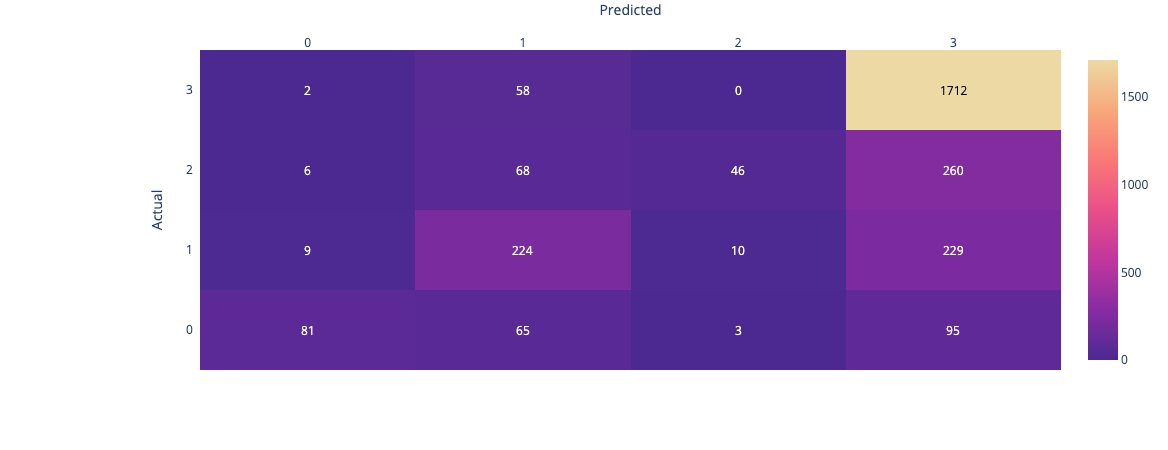

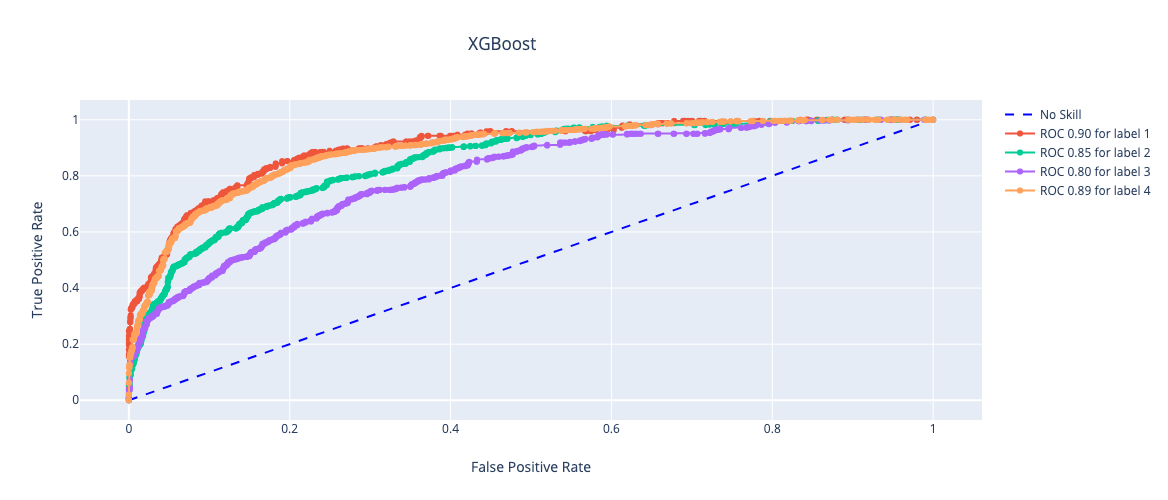

-----------------------------------------------------------------------------
LightGBM
CV Accuracy: 0.863 (0.012)
      Metric     Score
0   Accuracy  0.862622
1  Precision  0.864525
2     Recall  0.862622
3         F1  0.855170


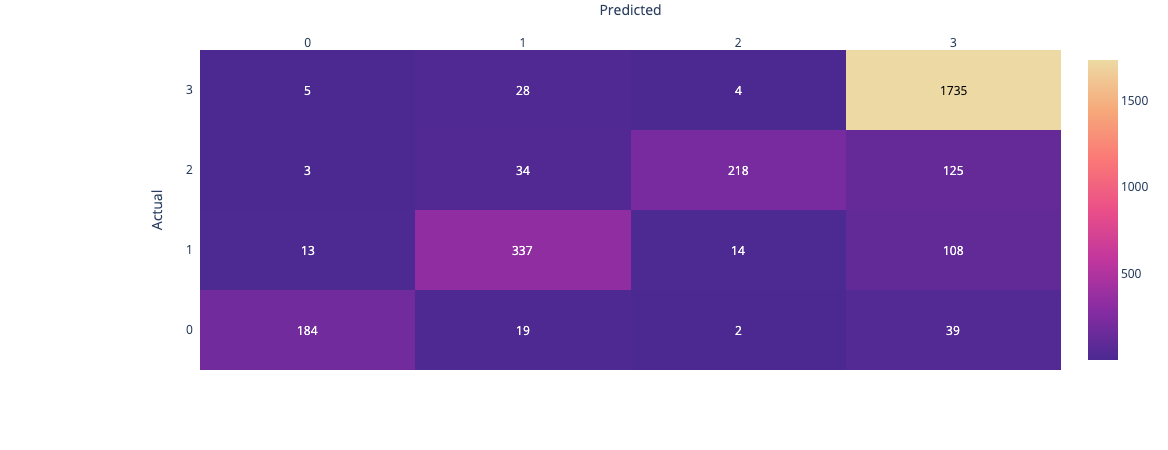

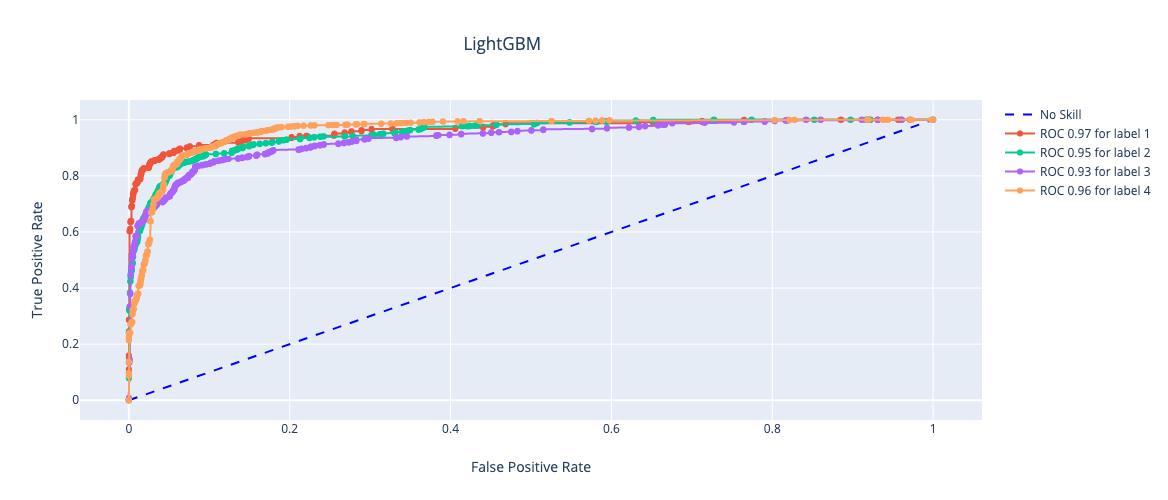

-----------------------------------------------------------------------------
AdaBoost
CV Accuracy: 0.658 (0.014)
      Metric     Score
0   Accuracy  0.656904
1  Precision  0.602221
2     Recall  0.656904
3         F1  0.601882


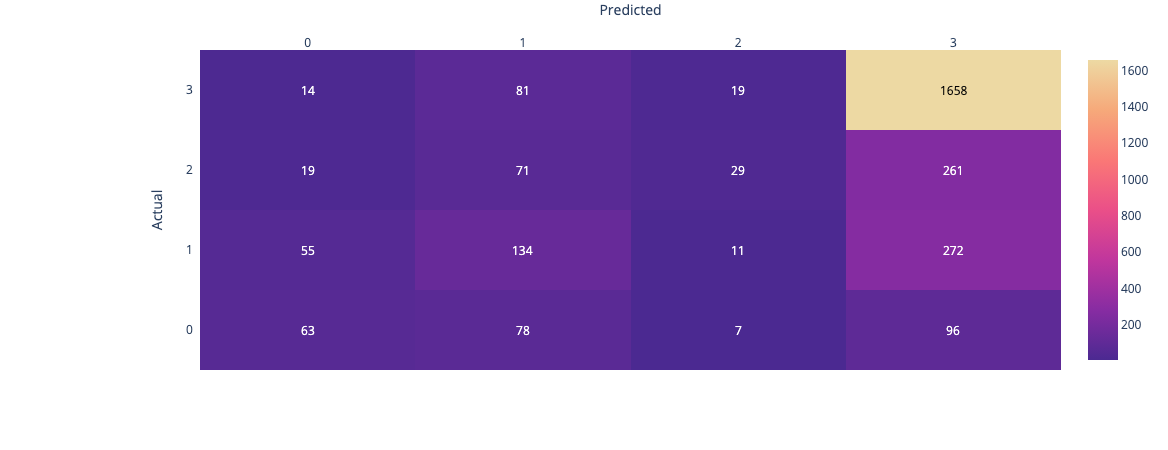

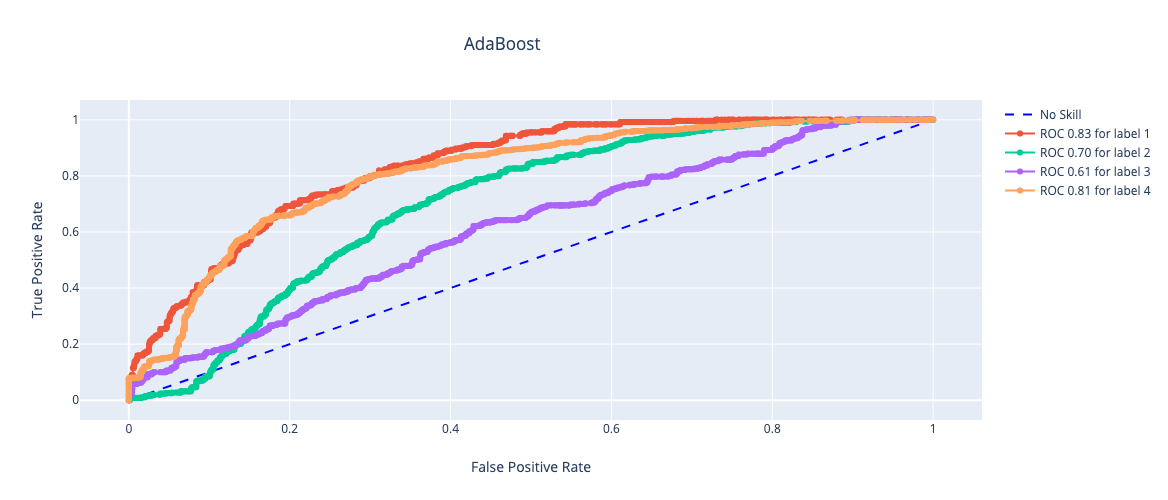

-----------------------------------------------------------------------------
CatBoost
CV Accuracy: 0.847 (0.016)
      Metric     Score
0   Accuracy  0.845537
1  Precision  0.840758
2     Recall  0.845537
3         F1  0.837842


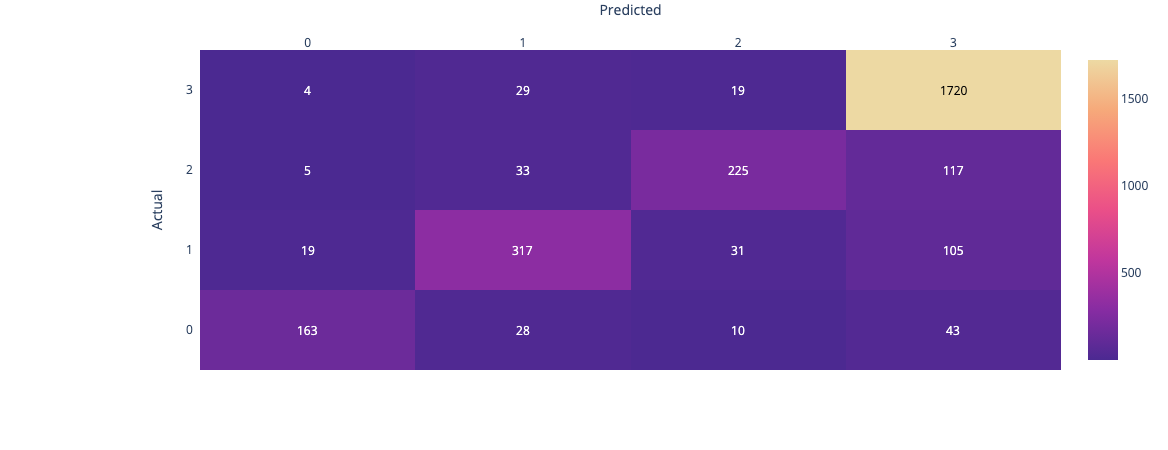

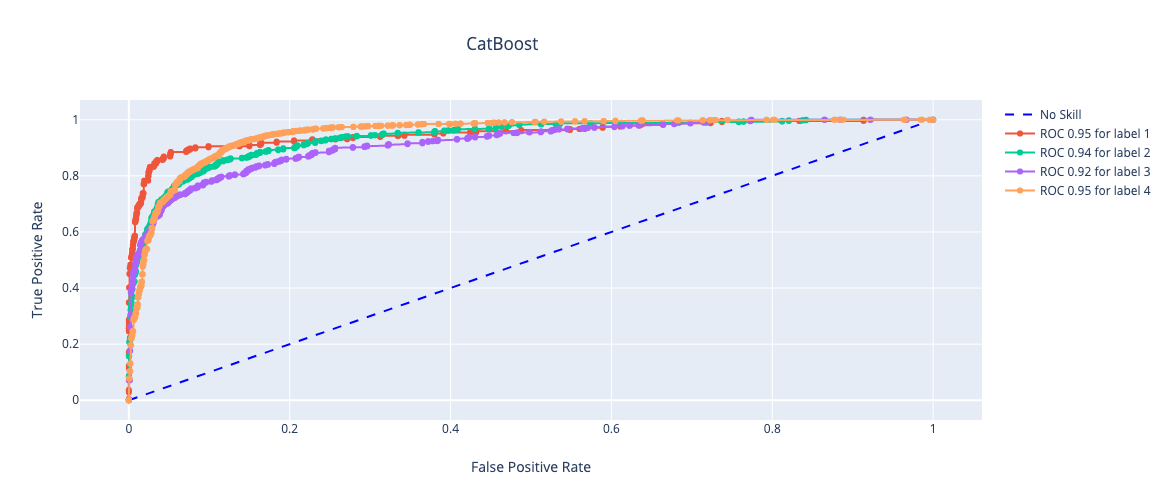

In [27]:
fitted_models = fit_models(xtrain, ytrain, xtest, ytest, models)

It seems that LightGBM returns the highest accuracy and F1 Score. We will continue with this model.

In [29]:
lgbm = fitted_models[1]

array([1])